# PHONE Notebook

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score

import optuna
import catboost as cb
import xgboost as xgb
import lightgbm as lgb


In [31]:
df = pd.read_csv('df_train_phone.csv')

In [32]:
num_col = ['tenure', 'totalcharges', 'monthlycharges']
target = 'churn'
X_col = [c for c in df.columns if c != target]
cat_col = [c for c in X_col if c not in num_col]


<Axes: xlabel='churn', ylabel='Count'>

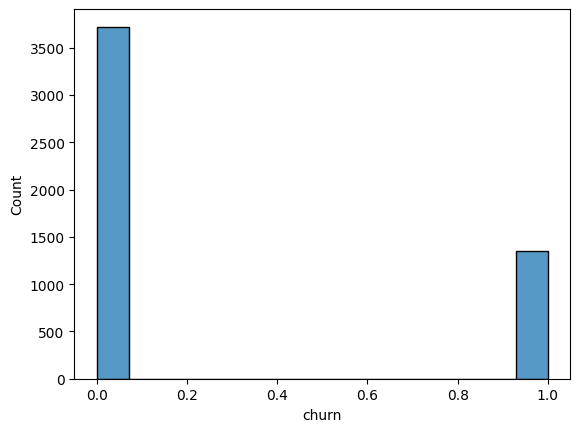

In [33]:
sns.histplot(data=df, x='churn')

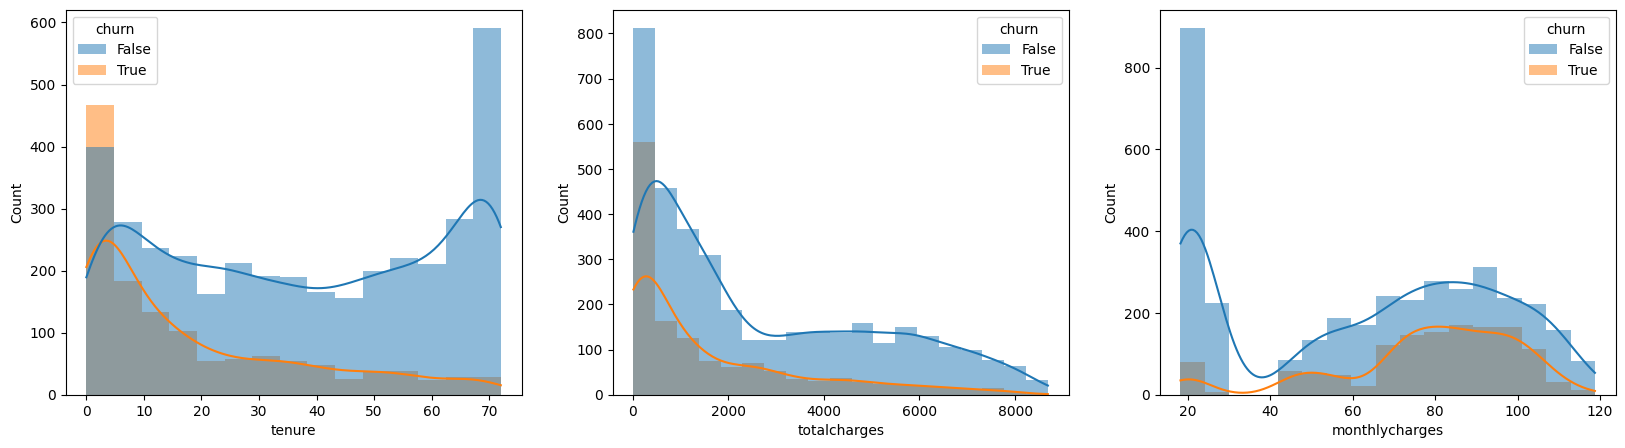

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for col, ax in zip(num_col, axes):
    sns.histplot(
        data=df, x=col, kde=True, ax=ax, hue=target, binwidth=df[col].std() /5, edgecolor=None
    )

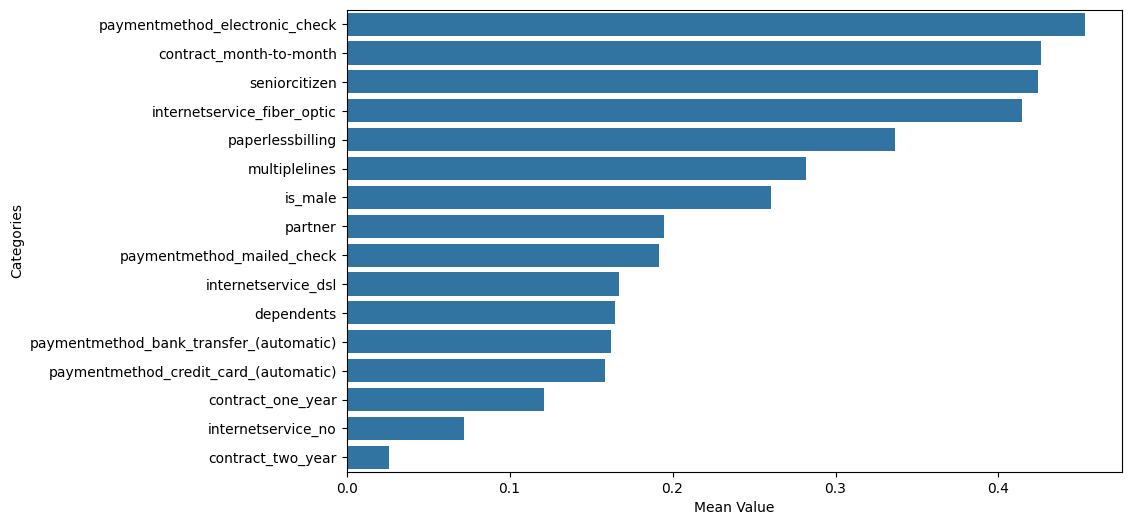

In [35]:
probability_of_churn_given_flag = df[df[target]][cat_col].sum() / df[cat_col].sum()
probability_of_churn_given_flag = probability_of_churn_given_flag.sort_values(ascending = False)

plt.figure(figsize=(10, 6))
sns.barplot(data=probability_of_churn_given_flag, orient= 'h')
plt.xlabel('Mean Value')
plt.ylabel('Categories')
plt.show()

In [36]:
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled.loc[:, num_col] = scaler.fit_transform(df_scaled[num_col])

In [37]:
pca = PCA()
X_pca = pca.fit_transform(df_scaled[X_col])
importances = pca.explained_variance_ratio_ / np.sum(pca.explained_variance_ratio_)
print(pd.Series(importances)[:3])

0    0.266090
1    0.193595
2    0.066860
dtype: float64


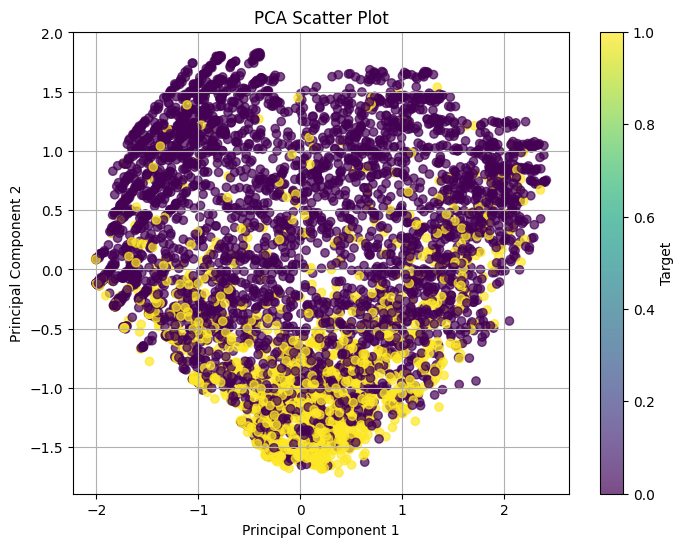

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df[target], cmap="viridis", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.colorbar(label="Target")
plt.grid()
plt.show()


In [39]:
fig = px.scatter_3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    color=df[target],
    labels={"x": "Principal Component 1", "y": "Principal Component 2", "z": "Principal Component 3"},
    title="3D PCA Scatter Plot",
)

fig.update_traces(marker={"size": 3})
fig.update_layout(width=1000, height=800)
fig.show()

In [40]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_scaled[X_col])

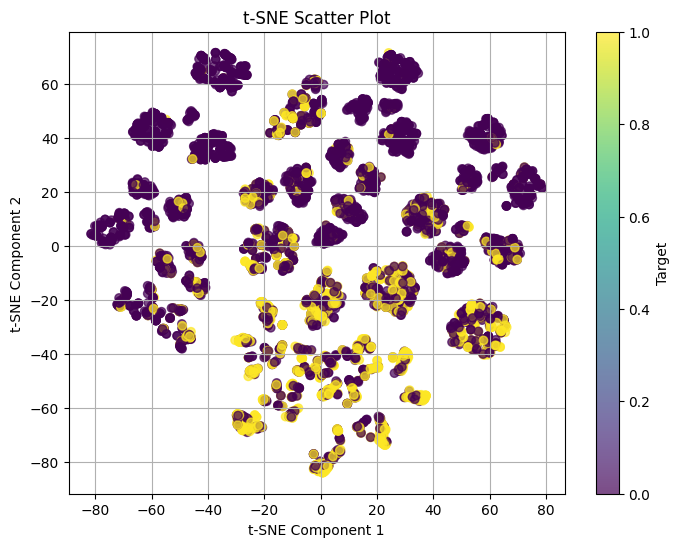

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df[target], cmap="viridis", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Scatter Plot")
plt.colorbar(label="Target")
plt.grid()
plt.show()

## Modelling

In [13]:
X = df[X_col]
y = df[target]

In [14]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## CatBoost

#### Parameters research

In [15]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 16, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 0.7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 0, 5),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2),
        'loss_function': 'Logloss',
        'eval_metric': 'Accuracy',
        'task_type': 'CPU',
    }

    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        scaler = MinMaxScaler()
        X_train.loc[:, num_col] = scaler.fit_transform(X_train[num_col])
        X_valid.loc[:, num_col] = scaler.transform(X_valid[num_col])
    
        # Create CatBoost Pool
        train_pool = cb.Pool(X_train, y_train)
        valid_pool = cb.Pool(X_valid, y_valid)
        
        # Initialize and train model
        model = cb.CatBoostClassifier(**param, 
                                      verbose=False, 
                                      early_stopping_rounds=15
                                      )
        model.fit(train_pool, 
                  eval_set=valid_pool, 
                  plot=False)
        
        # Predict and calculate accuracy
        preds = model.predict(valid_pool)
        scores.append(roc_auc_score(y_valid, preds))
    
    mean_score = np.mean(scores)
    return mean_score

# Create Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42),  pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))

# Optimize
study.optimize(objective, n_trials=20)

# Print best parameters
print("Best trial:", study.best_trial.params)

[I 2024-12-11 15:55:46,597] A new study created in memory with name: no-name-410566ad-0565-4def-ac2f-390f08f08b09
[I 2024-12-11 15:55:48,566] Trial 0 finished with value: 0.7077971609423128 and parameters: {'iterations': 687, 'depth': 8, 'learning_rate': 0.07587945476302646, 'l2_leaf_reg': 18.394633936788146, 'subsample': 0.44680559213273097, 'min_data_in_leaf': 0, 'random_strength': 0.21035886311957896}. Best is trial 0 with value: 0.7077971609423128.
[I 2024-12-11 15:55:50,016] Trial 1 finished with value: 0.702252732636754 and parameters: {'iterations': 933, 'depth': 7, 'learning_rate': 0.0737265320016441, 'l2_leaf_reg': 16.082337977183208, 'subsample': 0.6909729556485982, 'min_data_in_leaf': 4, 'random_strength': 0.5034443102887247}. Best is trial 0 with value: 0.7077971609423128.
[I 2024-12-11 15:55:51,248] Trial 2 finished with value: 0.6892384302508062 and parameters: {'iterations': 591, 'depth': 4, 'learning_rate': 0.0373818018663584, 'l2_leaf_reg': 18.09902572652895, 'subsampl

Best trial: {'iterations': 829, 'depth': 8, 'learning_rate': 0.05177498464404565, 'l2_leaf_reg': 18.717417748384015, 'subsample': 0.4323194953146931, 'min_data_in_leaf': 3, 'random_strength': 0.11669116910697097}


#### Testing

In [28]:
best_params = {'iterations': 829, 'depth': 8, 'learning_rate': 0.05177498464404565, 'l2_leaf_reg': 18.717417748384015, 'subsample': 0.4323194953146931, 'min_data_in_leaf': 3, 'random_strength': 0.11669116910697097}
model = cb.CatBoostClassifier(**best_params, verbose=False)
train_pool = cb.Pool(X, y)
test_pool = cb.Pool(X_test, y_test)
model.fit(train_pool)

In [29]:
print('CatBoost scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

CatBoost scores
Accuracy: 0.7922419460881
RocAuc: 0.6971823974512146
F1 : 0.5586592178770949


## XGBoost

#### Parameters research

In [18]:
def objective(trial):
    param = {
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        'n_estimators': trial.suggest_int('n_estimators', 800, 1200), 
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-3, 2),
        "alpha": trial.suggest_float("alpha", 1e-3, 2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "eta": trial.suggest_float("eta", 1e-2, 0.3),
        "gamma": trial.suggest_float("gamma", 1e-3, 3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "subsample": trial.suggest_float("subsample", 0.6, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.95),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
        "max_bin": trial.suggest_int("max_bin", 64, 255)
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
        model = xgb.XGBClassifier(**param, early_stopping_rounds=15)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        scores.append(accuracy_score(y_valid, preds))
    
    mean_score = np.mean(scores)   
    return mean_score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))
study.optimize(objective, n_trials=20)

print("Best trial:", study.best_trial.params)

[I 2024-12-11 15:56:21,172] A new study created in memory with name: no-name-826bfb00-d5fb-49e6-8942-6ab6e7eb1acf
[I 2024-12-11 15:56:21,702] Trial 0 finished with value: 0.750650911116416 and parameters: {'n_estimators': 950, 'booster': 'gbtree', 'lambda': 1.197718309909876, 'alpha': 0.31288126224443064, 'max_depth': 4, 'eta': 0.026844247528777843, 'gamma': 2.5986622611790304, 'min_child_weight': 5, 'subsample': 0.8478254022286159, 'colsample_bytree': 0.6072045730035308, 'grow_policy': 'depthwise', 'max_bin': 104}. Best is trial 0 with value: 0.750650911116416.
[I 2024-12-11 15:56:23,081] Trial 1 finished with value: 0.7847386010981141 and parameters: {'n_estimators': 872, 'booster': 'dart', 'lambda': 1.0499881068328434, 'alpha': 0.8644580922655895, 'max_depth': 5, 'eta': 0.18743733946949004, 'gamma': 0.41934208809547346, 'min_child_weight': 3, 'subsample': 0.7282266451527921, 'colsample_bytree': 0.7596244944759625, 'grow_policy': 'depthwise', 'max_bin': 162}. Best is trial 1 with val

Best trial: {'n_estimators': 1151, 'booster': 'gbtree', 'lambda': 1.9991286467604292, 'alpha': 1.6988522172238358, 'max_depth': 6, 'eta': 0.14626642949915453, 'gamma': 2.3041535764950822, 'min_child_weight': 4, 'subsample': 0.8371193713836992, 'colsample_bytree': 0.8021570132885433, 'grow_policy': 'lossguide', 'max_bin': 187}


#### Testing

In [24]:
best_params = {'n_estimators': 1151, 'booster': 'gbtree', 'lambda': 1.9991286467604292, 'alpha': 1.6988522172238358, 'max_depth': 6, 'eta': 0.14626642949915453, 'gamma': 2.3041535764950822, 'min_child_weight': 4, 'subsample': 0.8371193713836992, 'colsample_bytree': 0.8021570132885433, 'grow_policy': 'lossguide', 'max_bin': 187}
model = xgb.XGBClassifier(**best_params)
model.fit(X, y)

XGBClassifier(alpha=1.6988522172238358, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8021570132885433, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.14626642949915453, eval_metric=None, feature_types=None,
              gamma=2.3041535764950822, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              lambda=1.9991286467604292, learning_rate=None, max_bin=187,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1151, ...)

In [25]:
print('XGBoost scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

XGBoost scores
Accuracy: 0.8126232741617357
RocAuc: 0.7252289924332935
F1 : 0.6047156726768377


## LGBM

#### Parameters research

In [21]:

def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 40, 70),
        'max_depth': trial.suggest_int('max_depth', 6, 14),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 40, 70),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 2),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.95),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 5, 15),
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_error',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)        
    }
    
    kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        scaler = MinMaxScaler()
        X_train.loc[:, num_col] = scaler.fit_transform(X_train[num_col])
        X_valid.loc[:, num_col] = scaler.transform(X_valid[num_col])
        
        model = lgb.LGBMClassifier(**param, early_stopping_rounds=25, verbose=-1)
        model.fit(X_train, y_train, 
                  eval_set=[(X_valid, y_valid)], 
                  eval_metric='binary_error')
        
        preds = model.predict(X_valid)
        accuracies.append(accuracy_score(y_valid, preds))
    
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

# Create Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))

# Optimize
study.optimize(objective, n_trials=20)

# Print best parameters
print("Best trial:", study.best_trial.params)

[I 2024-12-11 15:56:55,122] A new study created in memory with name: no-name-49c01aa6-d7b3-4f6c-ab6e-456f2e56fe1d
[I 2024-12-11 15:56:56,365] Trial 0 finished with value: 0.8078334285532914 and parameters: {'num_leaves': 51, 'max_depth': 14, 'learning_rate': 0.07587945476302646, 'min_data_in_leaf': 58, 'lambda_l1': 0.39643541684062933, 'lambda_l2': 0.39638958863878504, 'feature_fraction': 0.6203292642588698, 'bagging_fraction': 0.9031616510212273, 'bagging_freq': 11, 'n_estimators': 383}. Best is trial 0 with value: 0.8078334285532914.
[I 2024-12-11 15:56:57,453] Trial 1 finished with value: 0.80586713641846 and parameters: {'num_leaves': 40, 'max_depth': 14, 'learning_rate': 0.08491983767203796, 'min_data_in_leaf': 46, 'lambda_l1': 0.4454674376934912, 'lambda_l2': 0.4484685687215243, 'feature_fraction': 0.7064847850358382, 'bagging_fraction': 0.7836647510712832, 'bagging_freq': 9, 'n_estimators': 216}. Best is trial 0 with value: 0.8078334285532914.
[I 2024-12-11 15:56:58,847] Trial 2

Best trial: {'num_leaves': 60, 'max_depth': 9, 'learning_rate': 0.0699882075376947, 'min_data_in_leaf': 54, 'lambda_l1': 0.10945086731027609, 'lambda_l2': 0.1450212818610811, 'feature_fraction': 0.8123334609943698, 'bagging_fraction': 0.7345514547732371, 'bagging_freq': 7, 'n_estimators': 340}


#### Testing

In [26]:
best_params = {'num_leaves': 60, 'max_depth': 9, 'learning_rate': 0.0699882075376947, 'min_data_in_leaf': 54, 'lambda_l1': 0.10945086731027609, 'lambda_l2': 0.1450212818610811, 'feature_fraction': 0.8123334609943698, 'bagging_fraction': 0.7345514547732371, 'bagging_freq': 7, 'n_estimators': 340}
model = lgb.LGBMClassifier(**best_params, verbose = -1)
model.fit(X, y)

LGBMClassifier(bagging_fraction=0.7345514547732371, bagging_freq=7,
               feature_fraction=0.8123334609943698,
               lambda_l1=0.10945086731027609, lambda_l2=0.1450212818610811,
               learning_rate=0.0699882075376947, max_depth=9,
               min_data_in_leaf=54, n_estimators=340, num_leaves=60,
               verbose=-1)

In [27]:
print('LGBM scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

LGBM scores
Accuracy: 0.7889546351084813
RocAuc: 0.7004480286738352
F1 : 0.563265306122449
